<a href="https://colab.research.google.com/github/jess22jess/EDPII/blob/main/M%C3%A9t_Elemento_Finito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MÉTODO DE ELEMENTOS FINITOS
**EDP II**

**Jessica Beatriz Arcos Gutiérrez**

---

**Descripción:**

Resuelve la ecuación:
$${-\frac{d^2u}{dx^2} + u = x }$$

con condiciones:
- **Condición inicial:** $u(0) = u(1) = 0$
- **Dominio:** $0 \leq x \leq 1$
---

El método de Elementos Finitos es una técnica numérica que divide el dominio en elementos pequeños y utiliza funciones de forma simples en cada elemento. En este código resolvemos el problema usando 4 elementos lineales.

---

### **Procedimiento:**

 El dominio [0,1] se divide en 4 elementos iguales de longitud \( h = 0.25 \). En cada elemento se usan funciones lineales:
   $\beta_1(\xi) = 1 - \frac{\xi}{h}, \quad \beta_2(\xi) = \frac{\xi}{h}$
   dónde $\xi$  es la coordenada local dentro del elemento.

Multiplicamos la ecuación por una función test e integramos por partes:
   $\int_0^1 [u'(x)v'(x) + u(x)v(x)]\,dx = \int_0^1 x\,v(x)\,dx$

Calculamos las integrales para cada elemento y sumamos sus contribuciones a la matriz global \( K \) y vector global \( F \).

Resolvemos el sistema lineal $K\alpha = F $ para obtener los valores de la solución en los nodos.

La solución aproximada se construye como: $u_N(x) = \sum_{i=1}^3 \alpha_i \beta_i(x)$

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [76]:
x = sp.symbols('x') # variable
u = sp.Function('u') # función

In [77]:
ode = -u(x).diff(x, 2) + u(x) - x
sol_exact = sp.dsolve(ode, ics={u(0): 0, u(1): 0})
sol_exact  # solución exacta

Eq(u(x), x - E*exp(x)/(-1 + exp(2)) + E*exp(-x)/(-1 + exp(2)))

In [78]:
u_exact_expr = sol_exact.rhs
u_exact_fn = sp.lambdify(x, u_exact_expr, 'numpy')

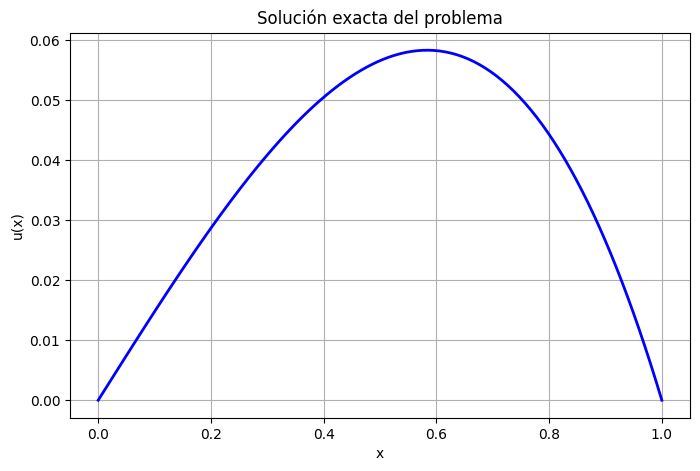

In [79]:
xx = np.linspace(0, 1, 100)
yy_exact = u_exact_fn(xx)

plt.figure(figsize=(8,5))
plt.plot(xx, yy_exact, 'b-', linewidth=2)
plt.title('Solución exacta del problema')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid()
plt.show()

In [80]:
h = 1/4  # longitud de cada elemento
nodes = np.array([0, 0.25, 0.5, 0.75, 1.0])  # coordenadas nodales

In [81]:
K11 = 1/h + h/3
K12 = -1/h + h/6
K22 = 1/h + h/3

In [82]:
K = np.zeros((3, 3))
F = np.zeros(3)

In [83]:
for e in range(4):
    x_left = nodes[e]

    if e == 0:
        K[0,0] += K11
        F[0] += x_left*h/2 + h**2/6

    elif e == 1:
        K[0,0] += K11
        K[0,1] += K12
        K[1,0] += K12
        K[1,1] += K22
        F[0] += x_left*h/2 + h**2/3
        F[1] += x_left*h/2 + h**2/6

    elif e == 2:
        K[1,1] += K22
        K[1,2] += K12
        K[2,1] += K12
        K[2,2] += K22
        F[1] += x_left*h/2 + h**2/3
        F[2] += x_left*h/2 + h**2/6

    elif e == 3:
        K[2,2] += K11
        F[2] += x_left*h/2 + h**2/3

In [84]:
K = K/h
F = F/h

In [85]:
K

array([[ 32.66666667, -15.83333333,   0.        ],
       [-15.83333333,  32.66666667, -15.83333333],
       [  0.        , -15.83333333,  32.66666667]])

In [86]:
F

array([0.25, 0.5 , 0.75])

In [87]:
alpha = np.linalg.solve(K, F)

In [88]:
alpha

array([0.0352125 , 0.05685947, 0.05051862])

In [89]:
def phi1(x):
    if 0 <= x <= 0.25:
        return 4*x
    elif 0.25 <= x <= 0.5:
        return 2 - 4*x
    else:
        return 0

def phi2(x):
    if 0.25 <= x <= 0.5:
        return 4*x - 1
    elif 0.5 <= x <= 0.75:
        return 3 - 4*x
    else:
        return 0

def phi3(x):
    if 0.5 <= x <= 0.75:
        return 4*x - 2
    elif 0.75 <= x <= 1:
        return 4 - 4*x
    else:
        return 0

In [90]:
def u_fem(x):
    return alpha[0]*phi1(x) + alpha[1]*phi2(x) + alpha[2]*phi3(x)

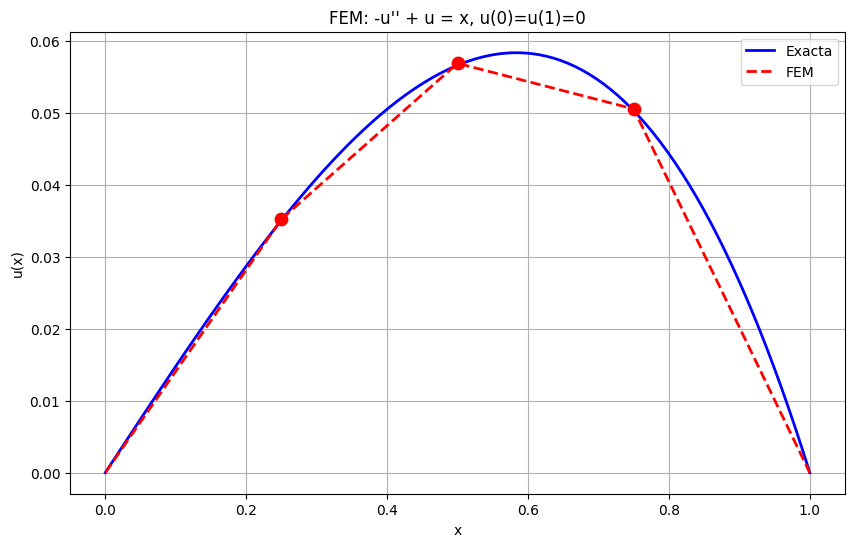

In [91]:
xx = np.linspace(0, 1, 100)
yy_fem = np.array([u_fem(xi) for xi in xx])

plt.figure(figsize=(10,6))
plt.plot(xx, yy_exact, 'b-', linewidth=2, label='Exacta')
plt.plot(xx, yy_fem, 'r--', linewidth=2, label='FEM')
plt.scatter([0.25, 0.5, 0.75], alpha, color='red', s=80, zorder=5)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('FEM: -u\'\' + u = x, u(0)=u(1)=0')
plt.legend()
plt.grid()
plt.show()

In [92]:
from tabulate import tabulate

x_vals = [0, 0.25, 0.5, 0.75, 1]
u_fem_vals = [0, alpha[0], alpha[1], alpha[2], 0]
u_exact_vals = [float(u_exact_expr.subs(x, val)) for val in x_vals]

tabla = []
for i in range(5):
    tabla.append([x_vals[i], f"{u_fem_vals[i]:.6f}", f"{u_exact_vals[i]:.6f}"])

print(tabulate(tabla, headers=['x', 'u_n', 'u_exact'], tablefmt='grid'))

+------+----------+-----------+
|    x |      u_n |   u_exact |
+======+==========+===========+
| 0    | 0        |  0        |
+------+----------+-----------+
| 0.25 | 0.035212 |  0.035048 |
+------+----------+-----------+
| 0.5  | 0.056859 |  0.056591 |
+------+----------+-----------+
| 0.75 | 0.050519 |  0.050276 |
+------+----------+-----------+
| 1    | 0        |  0        |
+------+----------+-----------+
